<div style="text-align: center;">

# Lab 3 – DS111  

</div>

**Tác giả:** Trần Yến Nhi – 23521117


In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def sample_gaussian(mean, cov, n, seed=None):
    if seed is not None:
        rng = np.random.default_rng(seed)
        return rng.multivariate_normal(mean, cov, size=n)
    return np.random.multivariate_normal(mean, cov, size=n)

def plot_points(X, title="", centers=None):
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], s=12, alpha=0.7)
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="X", s=180)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.grid(True)
    plt.show()


In [3]:
def init_centroids_random(X, K, seed=None):
    rng = np.random.default_rng(seed)
    idx = rng.choice(X.shape[0], size=K, replace=False)
    return X[idx].copy()

def e_step_assign(X, centroids):
    # trả về labels (N,) theo argmin khoảng cách bình phương
    # dist2 shape (N,K)
    dist2 = np.sum((X[:, None, :] - centroids[None, :, :])**2, axis=2)
    labels = np.argmin(dist2, axis=1)
    return labels, dist2

def m_step_update(X, labels, K, old_centroids=None):
    D = X.shape[1]
    centroids = np.zeros((K, D), dtype=float)
    for k in range(K):
        pts = X[labels == k]
        if len(pts) == 0:
            # cluster rỗng -> giữ nguyên (hoặc random lại)
            centroids[k] = old_centroids[k] if old_centroids is not None else X[np.random.randint(0, X.shape[0])]
        else:
            centroids[k] = pts.mean(axis=0)
    return centroids

def compute_objective_J(X, labels, centroids):
    # J = sum ||x - mu_{label}||^2
    return np.sum((X - centroids[labels])**2)

def kmeans_em_numpy(X, K=3, max_iters=100, tol=1e-6, seed=None, verbose=False):
    centroids = init_centroids_random(X, K, seed=seed)
    history_J = []

    for it in range(max_iters):
        # E-step: cố định mu, tối ưu r_{nk} (gán cụm)
        labels, _ = e_step_assign(X, centroids)

        # M-step: cố định r_{nk}, tối ưu mu_k (tính mean)
        new_centroids = m_step_update(X, labels, K, old_centroids=centroids)

        J = compute_objective_J(X, labels, new_centroids)
        history_J.append(J)

        shift = np.linalg.norm(new_centroids - centroids)
        if verbose:
            print(f"iter {it:03d} | J={J:.4f} | centroid_shift={shift:.6f}")

        if shift < tol:
            centroids = new_centroids
            break

        centroids = new_centroids

    return {
        "centroids": centroids,
        "labels": labels,
        "J_history": np.array(history_J),
        "n_iters": len(history_J)
    }


## Câu 1

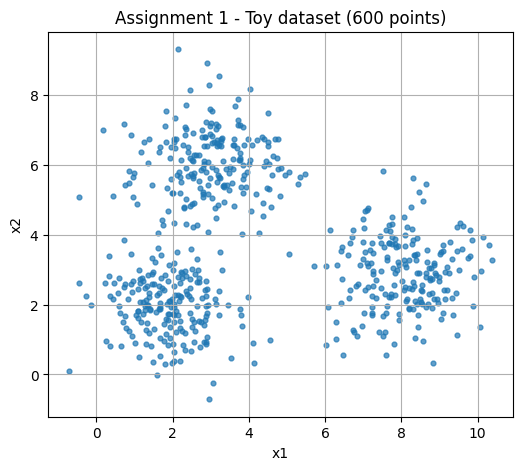

In [4]:
Sigma = np.array([[1, 0],
                  [0, 1]], dtype=float)

X1 = sample_gaussian(mean=(2,2), cov=Sigma, n=200, seed=1)
X2 = sample_gaussian(mean=(8,3), cov=Sigma, n=200, seed=2)
X3 = sample_gaussian(mean=(3,6), cov=Sigma, n=200, seed=3)

X = np.vstack([X1, X2, X3])
plot_points(X, title="Assignment 1 - Toy dataset (600 points)")


iter 000 | J=1138.6684 | centroid_shift=2.103449
iter 001 | J=1116.9826 | centroid_shift=0.092450
iter 002 | J=1116.9826 | centroid_shift=0.000000


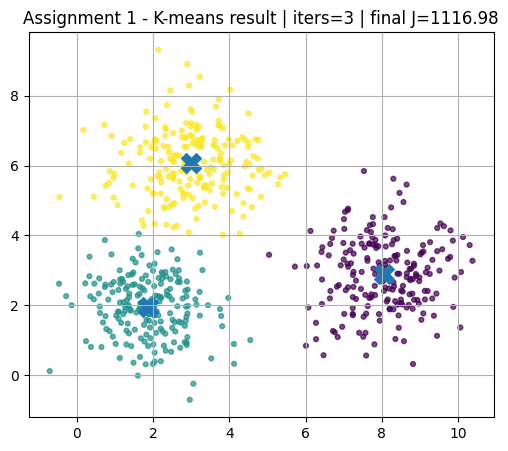

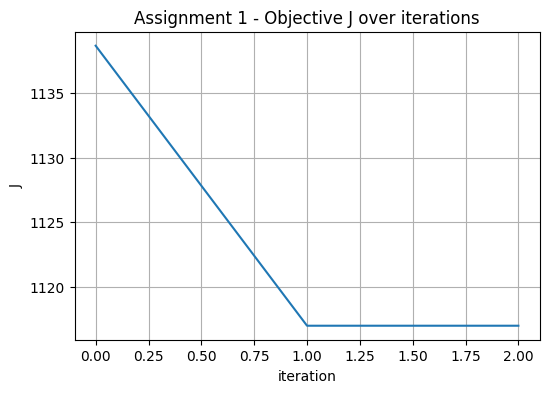

In [5]:
res = kmeans_em_numpy(X, K=3, max_iters=100, tol=1e-6, seed=42, verbose=True)

centroids = res["centroids"]
labels = res["labels"]

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=labels, s=12, alpha=0.7)
plt.scatter(centroids[:,0], centroids[:,1], marker="X", s=200)
plt.title(f"Assignment 1 - K-means result | iters={res['n_iters']} | final J={res['J_history'][-1]:.2f}")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(res["J_history"])
plt.title("Assignment 1 - Objective J over iterations")
plt.xlabel("iteration"); plt.ylabel("J")
plt.grid(True)
plt.show()


Assignment 1 - Random init experiments
Best  J: 1116.9825925414088 at seed 2
Worst J: 2798.75340912742 at seed 33
Mean  J: 1410.3789845449878
Std   J: 637.03523837817


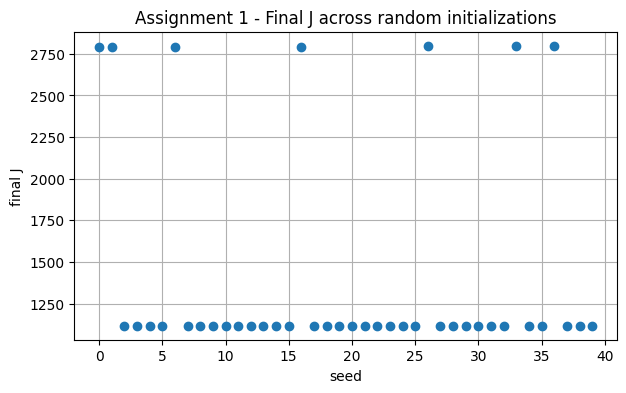

In [6]:
def run_many_inits(X, K=3, n_runs=30, max_iters=100, tol=1e-6):
    finals = []
    iters = []
    seeds = []
    for s in range(n_runs):
        out = kmeans_em_numpy(X, K=K, max_iters=max_iters, tol=tol, seed=s, verbose=False)
        finals.append(out["J_history"][-1])
        iters.append(out["n_iters"])
        seeds.append(s)
    return np.array(seeds), np.array(finals), np.array(iters)

seeds, final_J, n_iters = run_many_inits(X, K=3, n_runs=40)

print("Assignment 1 - Random init experiments")
print("Best  J:", final_J.min(), "at seed", seeds[np.argmin(final_J)])
print("Worst J:", final_J.max(), "at seed", seeds[np.argmax(final_J)])
print("Mean  J:", final_J.mean())
print("Std   J:", final_J.std())

plt.figure(figsize=(7,4))
plt.plot(seeds, final_J, marker="o", linestyle="none")
plt.title("Assignment 1 - Final J across random initializations")
plt.xlabel("seed"); plt.ylabel("final J")
plt.grid(True)
plt.show()


### Nhận xét

Trong bài toán này, ba cụm dữ liệu có:

kích thước bằng nhau (200–200–200),

phân phối đẳng hướng (ma trận hiệp phương sai là đơn vị),

các cụm tách biệt tương đối rõ ràng trong không gian 2 chiều.

Trong điều kiện lý tưởng như vậy, thuật toán K-means nhìn chung hội tụ nhanh và cho kết quả phân cụm hợp lý trong đa số các lần khởi tạo tâm cụm ngẫu nhiên. Tuy nhiên, do hàm mục tiêu của K-means là phi lồi, việc khởi tạo tâm cụm ban đầu vẫn có thể dẫn đến các nghiệm cực tiểu cục bộ khác nhau.

Cụ thể, khi các tâm cụm ban đầu được đặt gần các cụm thực sự trong dữ liệu, thuật toán sẽ hội tụ đến nghiệm tốt với giá trị hàm mục tiêu
𝐽
J nhỏ. Ngược lại, nếu các tâm cụm ban đầu nằm lệch hoặc gần nhau, thuật toán có thể hội tụ đến nghiệm kém hơn, dù vẫn thỏa điều kiện hội tụ.

Như vậy, khởi tạo ngẫu nhiên ảnh hưởng trực tiếp đến chất lượng nghiệm cuối cùng, dù trong bài toán cân bằng và dễ phân tách này, mức độ ảnh hưởng là tương đối nhỏ.

## Câu 2

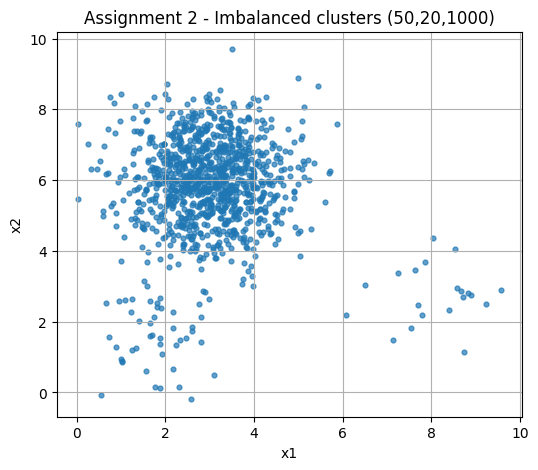

In [7]:
Sigma = np.array([[1, 0],
                  [0, 1]], dtype=float)

Y1 = sample_gaussian(mean=(2,2), cov=Sigma, n=50, seed=10)
Y2 = sample_gaussian(mean=(8,3), cov=Sigma, n=20, seed=11)
Y3 = sample_gaussian(mean=(3,6), cov=Sigma, n=1000, seed=12)

Y = np.vstack([Y1, Y2, Y3])
plot_points(Y, title="Assignment 2 - Imbalanced clusters (50,20,1000)")


iter 000 | J=2659.1974 | centroid_shift=1.570346
iter 001 | J=2212.1808 | centroid_shift=0.727273
iter 002 | J=2064.4451 | centroid_shift=0.374566
iter 003 | J=2008.1370 | centroid_shift=0.258497
iter 004 | J=1966.9441 | centroid_shift=0.254154
iter 005 | J=1932.9969 | centroid_shift=0.228421
iter 006 | J=1918.4785 | centroid_shift=0.144070
iter 007 | J=1912.9117 | centroid_shift=0.100756
iter 008 | J=1910.8156 | centroid_shift=0.053719
iter 009 | J=1909.4486 | centroid_shift=0.046745
iter 010 | J=1909.2000 | centroid_shift=0.022822
iter 011 | J=1908.9966 | centroid_shift=0.022035
iter 012 | J=1908.9966 | centroid_shift=0.000000


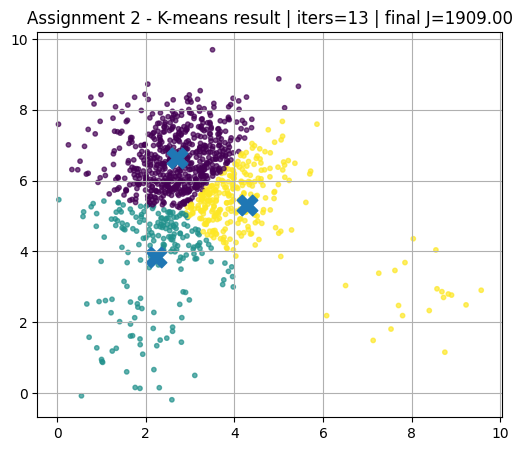

Cluster sizes (found): {np.int64(0): np.int64(593), np.int64(1): np.int64(196), np.int64(2): np.int64(281)}


In [8]:
res2 = kmeans_em_numpy(Y, K=3, max_iters=100, tol=1e-6, seed=0, verbose=True)

centroids2 = res2["centroids"]
labels2 = res2["labels"]

plt.figure(figsize=(6,5))
plt.scatter(Y[:,0], Y[:,1], c=labels2, s=10, alpha=0.7)
plt.scatter(centroids2[:,0], centroids2[:,1], marker="X", s=220)
plt.title(f"Assignment 2 - K-means result | iters={res2['n_iters']} | final J={res2['J_history'][-1]:.2f}")
plt.grid(True)
plt.show()

# thống kê size cụm
unique, counts = np.unique(labels2, return_counts=True)
print("Cluster sizes (found):", dict(zip(unique, counts)))


Assignment 2 - Random init experiments (imbalanced)
Best  J: 1889.489499426672 at seed 29
Worst J: 1986.733798105373 at seed 15
Mean  J: 1931.8700281584927
Std   J: 31.04752329110062


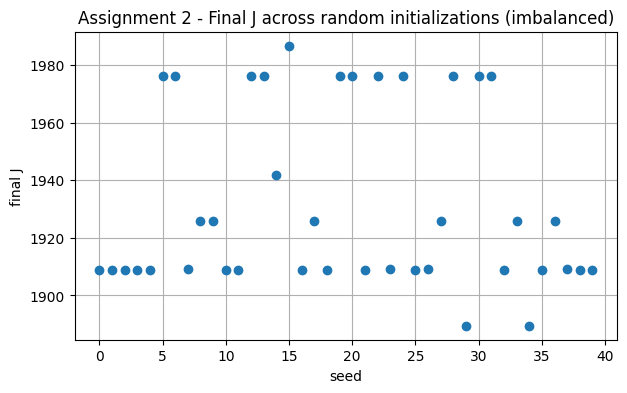

In [9]:
seeds2, final_J2, n_iters2 = run_many_inits(Y, K=3, n_runs=40)

print("Assignment 2 - Random init experiments (imbalanced)")
print("Best  J:", final_J2.min(), "at seed", seeds2[np.argmin(final_J2)])
print("Worst J:", final_J2.max(), "at seed", seeds2[np.argmax(final_J2)])
print("Mean  J:", final_J2.mean())
print("Std   J:", final_J2.std())

plt.figure(figsize=(7,4))
plt.plot(seeds2, final_J2, marker="o", linestyle="none")
plt.title("Assignment 2 - Final J across random initializations (imbalanced)")
plt.xlabel("seed"); plt.ylabel("final J")
plt.grid(True)
plt.show()


### Nhận xét

Trong bài toán này, ba cụm có kích thước rất chênh lệch (50, 20 và 1000 điểm). Do hàm mục tiêu của K-means là tổng sai số bình phương khoảng cách trong cụm, các cụm lớn đóng góp phần lớn giá trị của hàm mục tiêu.

Hệ quả là thuật toán K-means có xu hướng ưu tiên tối ưu hóa cụm lớn, trong khi các cụm nhỏ dễ bị:

gộp chung với cụm lớn,

hoặc bị kéo tâm cụm lệch khỏi vị trí trung tâm thực sự.

Ngoài ra, khi khởi tạo tâm cụm ngẫu nhiên, khả năng một tâm cụm ban đầu rơi vào vùng của cụm nhỏ là thấp hơn nhiều so với cụm lớn. Điều này làm tăng rủi ro thuật toán không nhận diện đúng các cụm nhỏ, đặc biệt trong những lần khởi tạo không thuận lợi.

Do đó, sự chênh lệch kích thước giữa các cụm làm giảm độ ổn định và độ chính xác của K-means, ngay cả khi các cụm có phân phối Gaussian và cùng hiệp phương sai.

## Câu 3

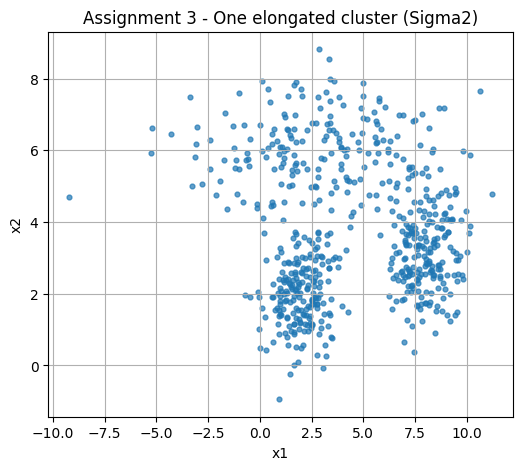

In [10]:
Sigma1 = np.array([[1, 0],
                   [0, 1]], dtype=float)

Sigma2 = np.array([[10, 0],
                   [0, 1]], dtype=float)

Z1 = sample_gaussian(mean=(2,2), cov=Sigma1, n=200, seed=21)
Z2 = sample_gaussian(mean=(8,3), cov=Sigma1, n=200, seed=22)
Z3 = sample_gaussian(mean=(3,6), cov=Sigma2, n=200, seed=23)

Z = np.vstack([Z1, Z2, Z3])
plot_points(Z, title="Assignment 3 - One elongated cluster (Sigma2)")


iter 000 | J=3787.4388 | centroid_shift=3.285525
iter 001 | J=3370.7326 | centroid_shift=1.059680
iter 002 | J=2931.6085 | centroid_shift=1.456057
iter 003 | J=2689.1410 | centroid_shift=0.780740
iter 004 | J=2610.4532 | centroid_shift=0.468306
iter 005 | J=2549.8200 | centroid_shift=0.456853
iter 006 | J=2506.6589 | centroid_shift=0.362404
iter 007 | J=2473.7522 | centroid_shift=0.317622
iter 008 | J=2430.3345 | centroid_shift=0.374536
iter 009 | J=2385.3117 | centroid_shift=0.370686
iter 010 | J=2345.5747 | centroid_shift=0.343165
iter 011 | J=2319.6507 | centroid_shift=0.264362
iter 012 | J=2312.4011 | centroid_shift=0.138317
iter 013 | J=2307.1737 | centroid_shift=0.114922
iter 014 | J=2307.1737 | centroid_shift=0.000000


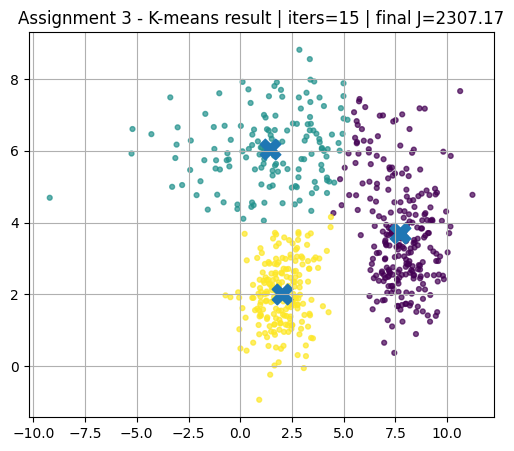

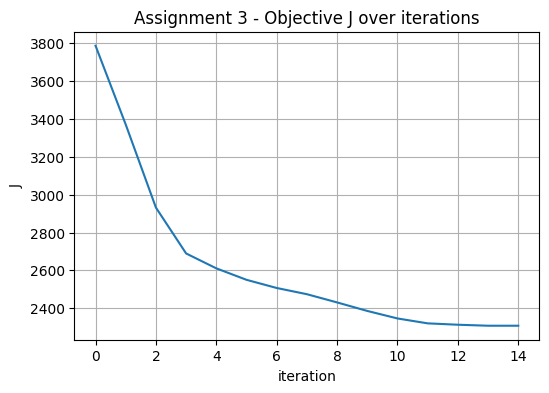

In [11]:
res3 = kmeans_em_numpy(Z, K=3, max_iters=200, tol=1e-6, seed=1, verbose=True)

centroids3 = res3["centroids"]
labels3 = res3["labels"]

plt.figure(figsize=(6,5))
plt.scatter(Z[:,0], Z[:,1], c=labels3, s=12, alpha=0.7)
plt.scatter(centroids3[:,0], centroids3[:,1], marker="X", s=220)
plt.title(f"Assignment 3 - K-means result | iters={res3['n_iters']} | final J={res3['J_history'][-1]:.2f}")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(res3["J_history"])
plt.title("Assignment 3 - Objective J over iterations")
plt.xlabel("iteration"); plt.ylabel("J")
plt.grid(True)
plt.show()


Assignment 3 - Random init experiments (elongated cluster)
Best  J: 2307.173720586107 at seed 0
Worst J: 2307.173720586107 at seed 0
Mean  J: 2307.173720586107
Std   J: 0.0


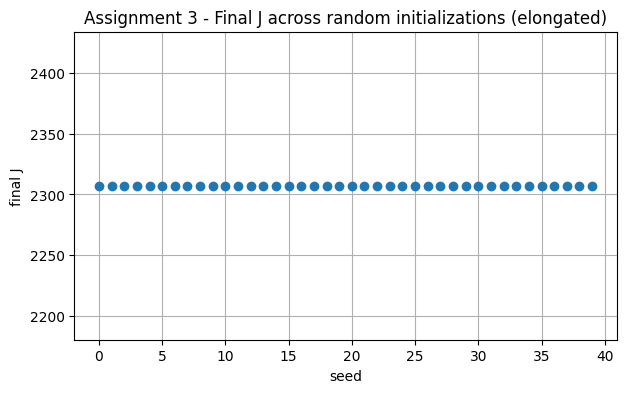

In [12]:
seeds3, final_J3, n_iters3 = run_many_inits(Z, K=3, n_runs=40, max_iters=200)

print("Assignment 3 - Random init experiments (elongated cluster)")
print("Best  J:", final_J3.min(), "at seed", seeds3[np.argmin(final_J3)])
print("Worst J:", final_J3.max(), "at seed", seeds3[np.argmax(final_J3)])
print("Mean  J:", final_J3.mean())
print("Std   J:", final_J3.std())

plt.figure(figsize=(7,4))
plt.plot(seeds3, final_J3, marker="o", linestyle="none")
plt.title("Assignment 3 - Final J across random initializations (elongated)")
plt.xlabel("seed"); plt.ylabel("final J")
plt.grid(True)
plt.show()


### Nhận xét

Trong bài toán này, hai cụm đầu có phân phối Gaussian đẳng hướng, trong khi cụm thứ ba có ma trận hiệp phương sai


dẫn đến phân phối kéo dài theo trục x.

Thuật toán K-means giả định mỗi cụm được mô tả tốt bởi một tâm duy nhất và khoảng cách Euclid, do đó hoạt động hiệu quả nhất với các cụm có dạng gần hình cầu. Với cụm bị kéo dài, giả định này không còn phù hợp.

Hệ quả là K-means có thể:

cắt cụm kéo dài thành nhiều phần,

hoặc đặt tâm cụm không đại diện tốt cho toàn bộ phân phối,

làm tăng độ nhạy của kết quả đối với khởi tạo ban đầu.

Vì vậy, sự khác biệt về hình dạng phân phối (anisotropic covariance) làm giảm hiệu quả của K-means, cho thấy hạn chế cố hữu của thuật toán khi xử lý các cụm không đẳng hướng.

### Tổng kết

Qua ba thí nghiệm, có thể thấy hiệu năng của K-means phụ thuộc mạnh vào giả định về hình dạng, kích thước và phân bố của các cụm, cũng như cách khởi tạo ban đầu. Mặc dù đơn giản và hiệu quả trong các trường hợp lý tưởng, K-means tỏ ra kém ổn định khi dữ liệu mất cân bằng hoặc có phân phối không đẳng hướng.